In [1]:
from fenics import *
from pyfftw import *
from numpy.random import default_rng
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib import cm
import time
import logging
import scipy.linalg
from scipy.optimize import fsolve
import sys
sys.path.insert(0, '/home/s2079009/MAC-MIGS/PhD/PhD_code/CES')
from utils import cov_functions
from utils import PDE_solver
from utils import circ_embedding
from utils import periodisation_smooth
from MLMCwLevDepCE import estimate_samples_LD
from MLMCwLevDepCE import MLMCwLevDepCircEmbedding

# suppress information messages (printing takes more time)
set_log_active(False)
logging.getLogger('FFC').setLevel(logging.WARNING)

# generator for random variables
rng = default_rng()

In [2]:
def f(k_l, m):
    alpha = 0.3551417357831946
    C = (2*4**(-alpha))/(np.exp(-3.631204069258538)*math.sqrt(pi))
    s=(2*m)**2
    # print(s)
    return C*k_l - s**(-alpha+1/2)*(s-k_l)**(5/4)

In [10]:
fsolve(f, 0, 256)

array([205320.29697143])

In [21]:
# k_l is the number of eigenvalues we discard
k_ls = [11, 63, 356, 1913, 9616, 45536, 205321]

In [11]:
# delta - rho = 0.3 - point evaluation

K_vec = np.array([128., 512., 2048., 8192., 32768.])
Y_hat_vec = np.load('./data/Y_hat_vec_delta_03.npy', allow_pickle=True)
delta_val = 0.5689590535005973
C_delta = -3.6269294735636546

In [12]:
# delta - rho = 0.1 - point evaluation

K_vec = np.array([128., 512., 2048., 8192., 32768.])
Y_hat_vec = np.load('./data/Y_hat_vec_delta_01.npy', allow_pickle=True)
delta_val = 0.5097811998975558
C_delta = -2.984574129568148

In [2]:
# delta = rho = 0.1 - L2 norm
Y_hat_vec_mlmc = np.load('../MLMCwCE/data/Y_hat_vec_01_norm.npy', allow_pickle=True)
delta_val_mlmc = 0.48512019149955105
C_delta_mlmc = -2.9384007391256293

Y_hat_var_vec_mlmc = np.load('../MLMCwCE/data/Y_hat_var_vec_01_norm.npy', allow_pickle=True)
delta_val_mlmc = 0.9825882140583038
C_delta_mlmc = -1.9871739238565482

s_vec = np.array([(4*4**l) for l in range(2, 8)])
# h_vec = 2*s_vec**(-1/2)

Y_hat_vec = np.load('./data/Y_hat_vec_delta_01_norm.npy', allow_pickle=True)
delta_val = np.load('./data/delta_01_norm.npy', allow_pickle=True)
C_delta = np.load('./data/C_delta_01_norm.npy', allow_pickle=True)

Y_hat_var_vec = np.load('./data/Y_hat_var_vec_delta_01_norm.npy', allow_pickle=True)
delta_var = np.load('./data/delta_var_01_norm.npy', allow_pickle=True)
C_delta_var = np.load('./data/C_delta_var_01_norm.npy', allow_pickle=True)

In [119]:
smoothing_error = np.array([0.7567728875553786, 0.6575024202314989, 0.5277794654755972, 0.3459347991169027, 0.1436291174341535, 0.04521137531370276, 0.012607290943529612, 0.003393291522795676]) # k_l = sqrt(s)

In [123]:
smoothing_error = np.array([0.5959355895126524, 1.0284307179676395, 1.533404670659852, 1.8650537316254794, 1.5973286609104518, 1.0192028857990387, 0.558729135895973, 0.2934965726031273]) # k_l with formula

In [125]:
s_vec = np.array([4, 16, 64, 256, 1024, 4096, 16384, 65536])
smooth_exp, smooth_const = np.polyfit(x=np.log(s_vec[3:]), y=np.log(smoothing_error[3:]), deg=1)
print(smooth_exp)
print(smooth_const)

-0.34255217477129674
2.709801600766371


In [ ]:
plt.figure(1, figsize=(10,8))
# use log-log scale

plt.loglog(s_vec, smoothing_error, 'k-x', label=r'$\|k-\tilde{k}\|_{\infty}$')
y_fit_alpha = np.exp(smooth_exp*np.log(s_vec[3:]) + smooth_const)
# plot best linear fit
plt.plot(s_vec[3:], 0.6*y_fit_alpha, 'r--', label=f'M^{round(smooth_exp, 2)}')

plt.title(r'$\mathbb{E}[Y_l]$ for different levels', fontsize=14)
plt.xlabel('M', fontsize=14)
plt.ylabel('log |mean|', fontsize=14)
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=16)
# plt.gca().invert_yaxis()
plt.show()

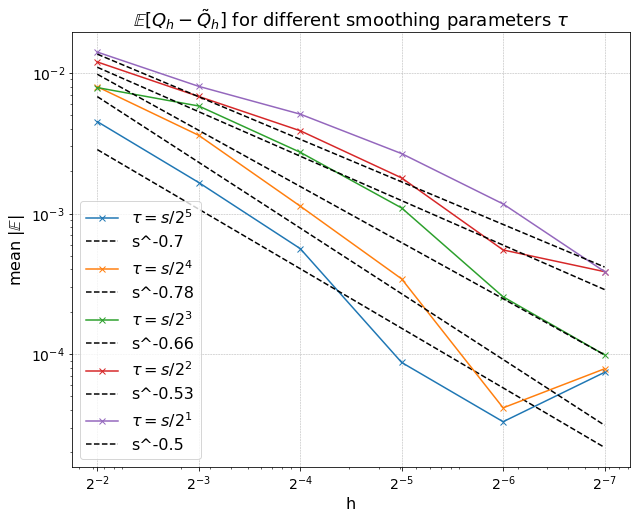

In [7]:
# plotting delta for mean value
plt.figure(1, figsize=(10,8))
# use log-log scale
for i in range(5):
    plt.loglog(s_vec, Y_hat_vec[i], '-x' , label=rf'$\tau=s/2^{5-i}$')
    # find y values for best linear fit
    y_fit_delta = np.exp(delta_val[i]*np.log(s_vec) + C_delta[i])
    # plot best linear fit
    plt.loglog(s_vec, 0.8*y_fit_delta, 'k--', label=f's^{round(delta_val[i], 2)}')

# plt.loglog(s_vec[2:], Y_hat_vec_mlmc[1:], 'k-x', label='MLMC')

plt.title(r'$\mathbb{E}[Q_h-\tilde{Q}_h]$ for different smoothing parameters $\tau$', fontsize=18)
plt.xlabel('h', fontsize=16)
plt.ylabel(r'mean $|\mathbb{E}|$', fontsize=16)
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(s_vec, ['$2^{-2}$','$2^{-3}$','$2^{-4}$','$2^{-5}$','$2^{-6}$','$2^{-7}$'], fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
# plt.gca().invert_yaxis()
# plt.show()
plt.savefig('mean_smoothing_error.png', dpi=300)

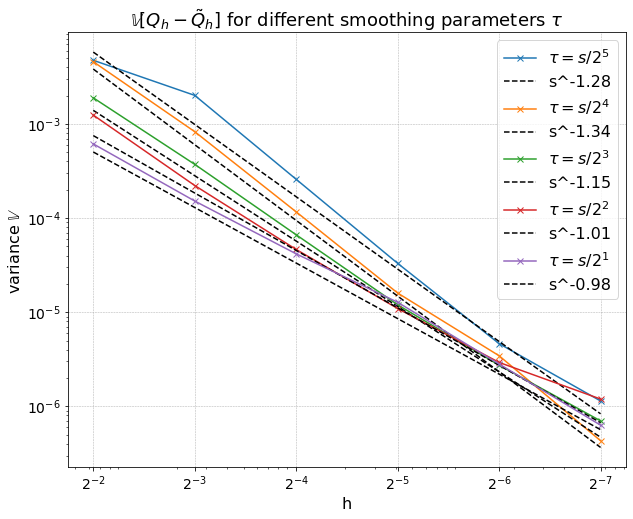

In [9]:
# plotting delta for variance
plt.figure(2, figsize=(10,8))
# use log-log scale
for i in range(5):
    plt.loglog(s_vec, Y_hat_var_vec[4-i], '-x' , label=rf'$\tau=s/2^{5-i}$')
    # find y values for best linear fit
    y_fit_delta = np.exp(delta_var[4-i]*np.log(s_vec) + C_delta_var[4-i])
    # plot best linear fit
    plt.plot(s_vec, 0.8*y_fit_delta, 'k--', label=f's^{round(delta_var[4-i], 2)}')

# plt.loglog(s_vec[2:], Y_hat_var_vec_mlmc[1:], 'k-x', label='MLMC')

plt.title(r'$\mathbb{V}[Q_h-\tilde{Q}_h]$ for different smoothing parameters $\tau$', fontsize=18)
plt.xlabel('h', fontsize=16)
plt.ylabel(r'variance $\mathbb{V}$', fontsize=16)
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(s_vec, ['$2^{-2}$','$2^{-3}$','$2^{-4}$','$2^{-5}$','$2^{-6}$','$2^{-7}$'], fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
# plt.gca().invert_yaxis()
plt.savefig('variance_smoothing_error.png', dpi=300)

In [11]:
Y_ls_vec_S_ld = []
Y_hat_vec_S_ld = []
Y_hat_var_vec_S_ld = []
Y_ls_vec_NS_ld = []
Y_hat_vec_NS_ld = []
Y_hat_var_vec_NS_ld = []

In [36]:
# pre-processing
Y_ls_NS_vec = np.load('./data/Y_l_LD_NS_6_01.npy', allow_pickle=True)
Y_ls_S_vec = np.load('./data/Y_l_LD_S_6_01.npy', allow_pickle=True)

In [37]:
Y_ls_vec_S_ld.append(Y_ls_S_vec)
Y_ls_vec_NS_ld.append(Y_ls_NS_vec)

In [38]:
Y_hat_vec_S_ld.append(np.abs(np.average(Y_ls_S_vec)))
print(Y_hat_vec_S_ld)
Y_hat_vec_NS_ld.append(np.abs(np.average(Y_ls_NS_vec)))
print(Y_hat_vec_NS_ld)

[0.6448194009164822, 0.004379423647670483, 0.0019642599728801713, 0.0022224339708067898, 0.0017987621329791932, 0.0011032539762593659, 0.00044218411576086046]
[0.6327712627176088, 0.003970092646068257, 0.0033519713759232062, 0.0013505892545687267, 0.001182197357117267, 0.0009018194787061666, 0.0004001571035994604]


In [39]:
Y_hat_var_vec_S_ld.append(1 / (len(Y_ls_S_vec)-1) * np.sum((Y_ls_S_vec - np.average(Y_ls_S_vec)) ** 2))
print(Y_hat_var_vec_S_ld)
Y_hat_var_vec_NS_ld.append(1 / (len(Y_ls_NS_vec)-1) * np.sum((Y_ls_NS_vec - np.average(Y_ls_NS_vec)) ** 2))
print(Y_hat_var_vec_NS_ld)

[0.002126584777108927, 0.0007700908653961595, 0.00037903695024118855, 8.782138500820956e-05, 4.065659106603089e-06, 7.23493307862371e-07, 1.8846308750485838e-07]
[0.0027905032107042862, 0.000897313618470343, 0.0003891334090288907, 8.781436100010833e-05, 4.062790612617989e-06, 7.217215251421391e-07, 1.8735537298029616e-07]


In [40]:
Y_ls_vec_S_ld = np.array(Y_ls_vec_S_ld)
Y_hat_vec_S_ld = np.array(Y_hat_vec_S_ld)
Y_hat_var_vec_S_ld = np.array(Y_hat_var_vec_S_ld)
Y_ls_vec_NS_ld = np.array(Y_ls_vec_NS_ld)
Y_hat_vec_NS_ld = np.array(Y_hat_vec_NS_ld)
Y_hat_var_vec_NS_ld = np.array(Y_hat_var_vec_NS_ld)

/tmp/ipykernel_13543/1382247561.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y_ls_vec_S_ld = np.array(Y_ls_vec_S_ld)
/tmp/ipykernel_13543/1382247561.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y_ls_vec_NS_ld = np.array(Y_ls_vec_NS_ld)


In [41]:
M_vec_ld = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
alpha_val_ld, C_alpha_ld = np.polyfit(x=np.log(M_vec_ld[1:]), y=np.log(Y_hat_vec_NS_ld[1:]), deg=1)
print(alpha_val_ld)
print(C_alpha_ld)
# compute beta and C_beta by finding best linear fit through Y_hat_vars
beta_val_ld, C_beta_ld = np.polyfit(x=np.log(M_vec_ld[1:]), y=np.log(Y_hat_var_vec_NS_ld[1:]), deg=1)
print(beta_val_ld)
print(C_beta_ld)

-0.3203869583916329
-4.125424298666542
-1.325511867482945
-0.935727804503858


In [49]:
np.save('./data/Y_hat_var_vec_S_LD_003_15_norm.npy', Y_hat_var_vec_S_ld, allow_pickle=True)

In [7]:
# alpha, beta - rho = 0.3 point evaluation

M_vec_ld = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
Y_hat_vec_S_ld = np.load('./data/Y_hat_vec_S_LD_03.npy', allow_pickle=True)
alpha_val_ld = 0.4759242229901104
C_alpha_ld = -3.0412220727573627
Y_hat_var_vec_S_ld = np.load('./data/Y_hat_var_vec_S_LD_03.npy', allow_pickle=True)
beta_val_ld = 0.9506734035674937
C_beta_ld = -1.4924312936229713
Y_ls_vec_S_ld = np.load('./data/Y_ls_vec_S_LD_03.npy', allow_pickle=True)

M_vec_ld = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
Y_hat_vec_NS_ld = np.load('./data/Y_hat_vec_NS_LD_03.npy', allow_pickle=True)
alpha_val_ld = 0.44236190432890393
C_alpha_ld = -3.3977088507672293
Y_hat_var_vec_NS_ld = np.load('./data/Y_hat_var_vec_NS_LD_03.npy', allow_pickle=True)
beta_val_ld = 0.9509908441481433
C_beta_ld = -1.4462067284096112
Y_ls_vec_NS_ld = np.load('./data/Y_ls_vec_NS_LD_03.npy', allow_pickle=True)

C_alpha_mlmc = -2.8857318719799454

In [ ]:
# alpha, beta - rho = 0.1 point evaluation
M_vec_ld = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
Y_hat_vec_S_ld = np.load('./data/Y_hat_vec_S_LD_01.npy', allow_pickle=True)
alpha_val_ld = 0.45691602982458696
C_alpha_ld = -2.9953839300774434
Y_hat_var_vec_S_ld = np.load('./data/Y_hat_var_vec_S_LD_01.npy', allow_pickle=True)
beta_val_ld = 0.8948572930115527
C_beta_ld = -1.4664492763073806
Y_ls_vec_S_ld = np.load('./data/Y_ls_vec_S_LD_01.npy', allow_pickle=True)

M_vec_ld = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
Y_hat_vec_NS_ld = np.load('./data/Y_hat_vec_NS_LD_01.npy', allow_pickle=True)
alpha_val_ld = 0.5201061022787089
C_alpha_ld = -3.1443293795010043
Y_hat_var_vec_NS_ld = np.load('./data/Y_hat_var_vec_NS_LD_01.npy', allow_pickle=True)
beta_val_ld = 0.9002933434343978
C_beta_ld = -1.4252171289268427
Y_ls_vec_NS_ld = np.load('./data/Y_ls_vec_NS_LD_01.npy', allow_pickle=True)

C_alpha_mlmc = -2.6442549190384215

In [ ]:
# alpha, beta - rho = 0.3 L2 norm

M_vec_ld = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
Y_hat_vec_S_ld = np.load('./data/Y_hat_vec_S_LD_03_norm.npy', allow_pickle=True)
Y_hat_var_vec_S_ld = np.load('./data/Y_hat_var_vec_S_LD_03_norm.npy', allow_pickle=True)
Y_ls_vec_S_ld = np.load('./data/Y_ls_vec_S_LD_03_norm.npy', allow_pickle=True)

M_vec_ld = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
Y_hat_vec_NS_ld = np.load('./data/Y_hat_vec_NS_LD_03_norm.npy', allow_pickle=True)
alpha_val_ld = 0.46197784746285264
C_alpha_ld = -3.518756717417821
Y_hat_var_vec_NS_ld = np.load('./data/Y_hat_var_vec_NS_LD_03_norm.npy', allow_pickle=True)
beta_val_ld = 0.952393363736092
C_beta_ld = -2.662107132286692
Y_ls_vec_NS_ld = np.load('./data/Y_ls_vec_NS_LD_03_norm.npy', allow_pickle=True)

C_alpha_mlmc = -3.1188811144015007

In [102]:
# alpha, beta - rho = 0.1 L2 norm

M_vec_ld = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
Y_hat_vec_S_ld = np.load('./data/Y_hat_vec_S_LD_01_norm.npy', allow_pickle=True)
Y_hat_var_vec_S_ld = np.load('./data/Y_hat_var_vec_S_LD_01_norm.npy', allow_pickle=True)
Y_ls_vec_S_ld = np.load('./data/Y_ls_vec_S_LD_01_norm.npy', allow_pickle=True)

M_vec_ld = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
Y_hat_vec_NS_ld = np.load('./data/Y_hat_vec_NS_LD_01_norm.npy', allow_pickle=True)
alpha_val_ld = 0.45005994861693355
C_alpha_ld = -3.6399011143397306
Y_hat_var_vec_NS_ld = np.load('./data/Y_hat_var_vec_NS_LD_01_norm.npy', allow_pickle=True)
beta_val_ld = 0.9543708643603449
C_beta_ld = -2.2745615564750317
Y_ls_vec_NS_ld = np.load('./data/Y_ls_vec_NS_LD_01_norm.npy', allow_pickle=True)

C_alpha_mlmc = -2.9384007391256293

In [ ]:
# alpha, beta - rho = 0.1 and nu=1.5 point evaluation

M_vec_ld = np.array([4, 16, 64, 256, 1024, 4096, 16384, 65536])
Y_hat_vec_S_ld = np.load('./data/Y_hat_vec_S_LD_01_15.npy', allow_pickle=True)
Y_hat_var_vec_S_ld = np.load('./data/Y_hat_var_vec_S_LD_01_15.npy', allow_pickle=True)
Y_ls_vec_S_ld = np.load('./data/Y_ls_vec_S_LD_01_15.npy', allow_pickle=True)

M_vec_ld = np.array([4, 16, 64, 256, 1024, 4096, 16384, 65536])
Y_hat_vec_NS_ld = np.load('./data/Y_hat_vec_NS_LD_01_15.npy', allow_pickle=True)
alpha_val_ld = 0.4642438820225041
C_alpha_ld = -3.4196336504103244
Y_hat_var_vec_NS_ld = np.load('./data/Y_hat_var_vec_NS_LD_01_15.npy', allow_pickle=True)
beta_val_ld = 1.1877428864864756
C_beta_ld = -0.5937307571490574
Y_ls_vec_NS_ld = np.load('./data/Y_ls_vec_NS_LD_01_15.npy', allow_pickle=True)

C_alpha_mlmc = -3.0178444273516067

In [ ]:
# alpha, beta - rho = 0.1 and nu=1.5 L2 norm

M_vec_ld = np.array([4, 16, 64, 256, 1024, 4096, 16384, 65536])
Y_hat_vec_S_ld = np.load('./data/Y_hat_vec_S_LD_01_15_norm.npy', allow_pickle=True)
Y_hat_var_vec_S_ld = np.load('./data/Y_hat_var_vec_S_LD_01_15_norm.npy', allow_pickle=True)
Y_ls_vec_S_ld = np.load('./data/Y_ls_vec_S_LD_01_15_norm.npy', allow_pickle=True)

M_vec_ld = np.array([4, 16, 64, 256, 1024, 4096, 16384, 65536])
Y_hat_vec_NS_ld = np.load('./data/Y_hat_vec_NS_LD_01_15_norm.npy', allow_pickle=True)
alpha_val_ld = 0.5609389916195612
C_alpha_ld = -2.9422970825490085
Y_hat_var_vec_NS_ld = np.load('./data/Y_hat_var_vec_NS_LD_01_15_norm.npy', allow_pickle=True)
beta_val_ld = 1.2175715201923831
C_beta_ld = -1.8646758531940137
Y_ls_vec_NS_ld = np.load('./data/Y_ls_vec_NS_LD_01_15_norm.npy', allow_pickle=True)

C_alpha_mlmc = -2.886461202278576

In [55]:
# alpha, beta - rho = 0.03 and nu=1.5 point evaluation

M_vec_ld = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
Y_hat_vec_S_ld = np.load('./data/Y_hat_vec_S_LD_003_15.npy', allow_pickle=True)
Y_hat_var_vec_S_ld = np.load('./data/Y_hat_var_vec_S_LD_003_15.npy', allow_pickle=True)
Y_ls_vec_S_ld = np.load('./data/Y_ls_vec_S_LD_003_15.npy', allow_pickle=True)

Y_hat_vec_NS_ld = np.load('./data/Y_hat_vec_NS_LD_003_15.npy', allow_pickle=True)
alpha_val_ld = 0.4658568238388773
C_alpha_ld = -2.3199050818012976
Y_hat_var_vec_NS_ld = np.load('./data/Y_hat_var_vec_NS_LD_003_15.npy', allow_pickle=True)
beta_val_ld = 1.1317480782216376
C_beta_ld = -1.0613758121073453
Y_ls_vec_NS_ld = np.load('./data/Y_ls_vec_NS_LD_003_15.npy', allow_pickle=True)

C_alpha_mlmc = -3.053440188533286

In [54]:
# alpha, beta - rho = 0.03 and nu=1.5 L2 norm

M_vec_ld = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
Y_hat_vec_S_ld = np.load('./data/Y_hat_vec_S_LD_003_15_norm.npy', allow_pickle=True)
Y_hat_var_vec_S_ld = np.load('./data/Y_hat_var_vec_S_LD_003_15_norm.npy', allow_pickle=True)
Y_ls_vec_S_ld = np.load('./data/Y_ls_vec_S_LD_003_15_norm.npy', allow_pickle=True)

Y_hat_vec_NS_ld = np.load('./data/Y_hat_vec_NS_LD_003_15_norm.npy', allow_pickle=True)
alpha_val_ld = 0.3203869583916329
C_alpha_ld = -4.125424298666542
Y_hat_var_vec_NS_ld = np.load('./data/Y_hat_var_vec_NS_LD_003_15_norm.npy', allow_pickle=True)
beta_val_ld = 1.325511867482945
C_beta_ld = -0.935727804503858
Y_ls_vec_NS_ld = np.load('./data/Y_ls_vec_NS_LD_003_15_norm.npy', allow_pickle=True)

C_alpha_mlmc = -3.631204069258538

In [101]:
Y_hat_vec_mlmc = np.load('../MLMCwCE/data/Y_hat_vec_01_norm.npy', allow_pickle=True)

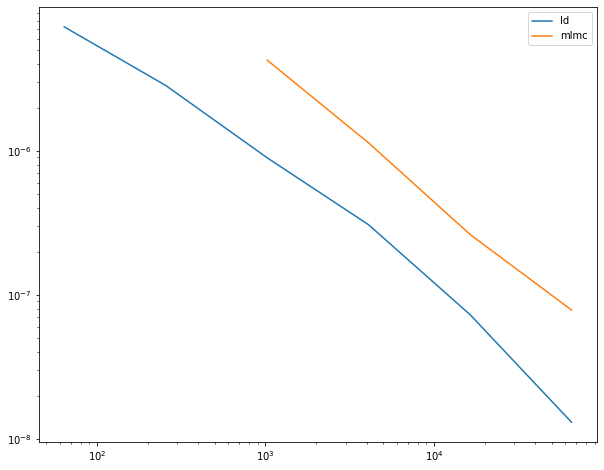

In [114]:
plt.figure(figsize=(10,8))
plt.loglog(M_vec_ld[1:], (Y_hat_vec_NS_ld[1:]/(1-C_alpha_ld/C_alpha_mlmc*4**alpha_val_ld))**2, label='ld')
plt.loglog(M_vec_ld[3:], (Y_hat_vec_mlmc[1:]/(1-4**0.4599735240350363))**2, label='mlmc')
plt.legend()
plt.show()

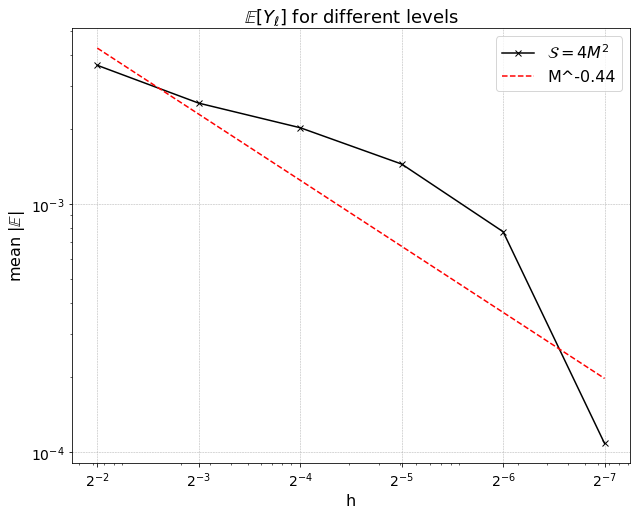

In [18]:
# plotting alpha
plt.figure(3, figsize=(10,8))
# use log-log scale
plt.loglog(M_vec_ld[1:], Y_hat_vec_NS_ld[1:], 'k-x' , label=r'$\mathcal{S}=4M^2$')
# plt.loglog(M_vec_ld[1:], Y_hat_vec_S_ld[1:])
# plt.loglog(M_vec_ld[3:], Y_hat_vec_mlmc[1:], label='mlmc')
# find y values for best linear fit
y_fit_alpha = np.exp(-alpha_val_ld*np.log(M_vec_ld[1:]) + C_alpha_ld)
# plot best linear fit
plt.plot(M_vec_ld[1:], 0.8*y_fit_alpha, 'r--', label=f'M^-{round(alpha_val_ld, 2)}')

plt.title(r'$\mathbb{E}[Y_\ell]$ for different levels', fontsize=18)
plt.xlabel('h', fontsize=16)
plt.ylabel(r'mean $|\mathbb{E}|$', fontsize=16)
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(s_vec, ['$2^{-2}$','$2^{-3}$','$2^{-4}$','$2^{-5}$','$2^{-6}$','$2^{-7}$'], fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

# plt.ylabel(r'variance $\mathbb{V}$', fontsize=16)

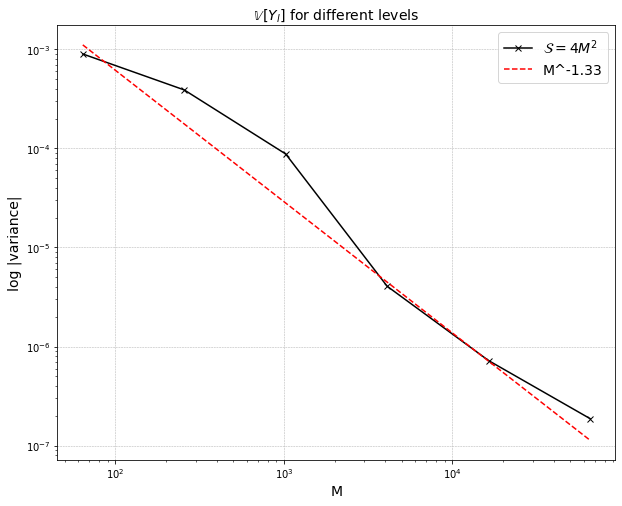

In [52]:
# plotting beta
plt.figure(4, figsize=(10,8)) 
# use log-log scale
plt.loglog(M_vec_ld[1:], Y_hat_var_vec_NS_ld[1:], 'k-x' , label=r'$\mathcal{S}=4M^2$')
# y values for best linear fit
y_fit_beta = np.exp(-beta_val_ld*np.log(M_vec_ld[1:]) + C_beta_ld)
# plot linear fit
plt.plot(M_vec_ld[1:], 0.7*y_fit_beta, 'r--', label=f'M^-{round(beta_val_ld, 2)}')

plt.title(r'$\mathbb{V} \, [Y_l]$ for different levels', fontsize=14)
plt.xlabel('M', fontsize=14)
plt.ylabel('log |variance|', fontsize=14)
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=14)
plt.show()

In [ ]:
# gamma - rho = 0.3

M_vec = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
avg_times_vec = np.load('./data/avg_times_vec_LD_03.npy', allow_pickle=True)
gamma_val = 0.9375960062806579
C_gamma = -7.683282802718193

In [58]:
# gamma - rho = 0.1
M_vec = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
avg_times_vec = np.load('./data/avg_times_vec_LD_01.npy', allow_pickle=True)
gamma_val = 0.9290889899937642
C_gamma = -7.597688614618549

In [61]:
# gamma - rho = 0.03 and nu = 1.5
M_vec = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
avg_times_vec = np.load('./data/avg_times_vec_LD_15.npy', allow_pickle=True)
avg_times_vec = avg_times_vec[1:]
gamma_val = 0.8700621125059221
C_gamma = -7.510443908031861

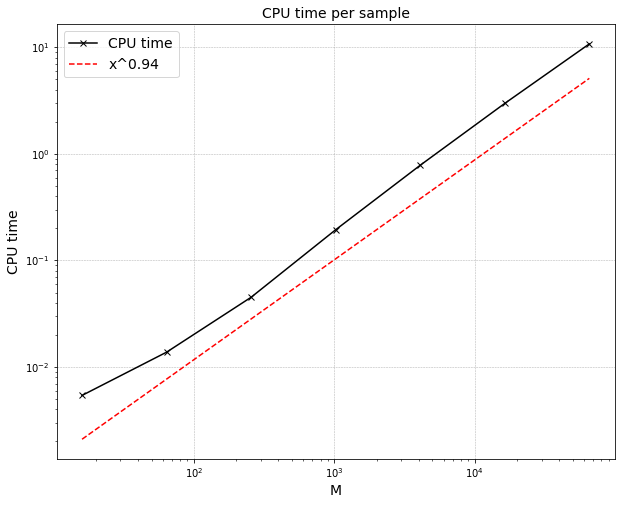

In [62]:
# THIS CELL IS FOR PLOTTING GAMMA
plt.figure(5, figsize=(10,8))
# use log-log scale
plt.loglog(M_vec, avg_times_vec, 'k-x' ,label='CPU time')

# the graph is more like a curve so we fit 2 lines - one through the first 4 
# points and last 3 points. The average should be close to gamma_val.

# line through first 4 points 
gamma, C_gamma = \
    np.polyfit(x=np.log(M_vec), y=np.log(avg_times_vec), deg=1)
y_fit_gamma = np.exp(gamma*np.log(M_vec) + C_gamma)
plt.plot(M_vec, 0.5*y_fit_gamma, 'r--', label=f'x^{round(gamma, 2)}')

plt.title('CPU time per sample', fontsize=14)
plt.xlabel('M', fontsize=14)
plt.ylabel('CPU time', fontsize=14)
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=14)
plt.show()

In [ ]:
# parameters - rho = 0.3 - point evaluation
Y_hat_vec_S = np.load('./data/Y_hat_vec_S_LD_03.npy', allow_pickle=True)
Y_hat_vec_NS = np.load('./data/Y_hat_vec_NS_LD_03.npy', allow_pickle=True)
alpha_val = 0.44236190432890393
C_alpha = -3.3977088507672293
Y_hat_var_vec_S = np.load('./data/Y_hat_var_vec_S_LD_03.npy', allow_pickle=True)
Y_hat_var_vec_NS = np.load('./data/Y_hat_var_vec_NS_LD_03.npy', allow_pickle=True)
beta_val = 0.9509908441481433
C_beta = -1.4462067284096112
Y_ls_vec_S = np.load('./data/Y_ls_vec_S_LD_03.npy', allow_pickle=True)
Y_ls_vec_NS = np.load('./data/Y_ls_vec_NS_LD_03.npy', allow_pickle=True)
avg_times_vec = np.load('./data/avg_times_vec_LD_03.npy', allow_pickle=True)
gamma_val = 0.9375960062806579
C_gamma = -7.683282802718193
C_alpha_mlmc = -2.8857318719799454

In [ ]:
# parameters - rho = 0.1 - point evaluation
Y_hat_vec_S = np.load('./data/Y_hat_vec_S_LD_01.npy', allow_pickle=True)
Y_hat_vec_NS = np.load('./data/Y_hat_vec_NS_LD_01.npy', allow_pickle=True)
alpha_val = 0.5201061022787089
C_alpha = -3.1443293795010043
Y_hat_var_vec_S = np.load('./data/Y_hat_var_vec_S_LD_01.npy', allow_pickle=True)
Y_hat_var_vec_NS = np.load('./data/Y_hat_var_vec_NS_LD_01.npy', allow_pickle=True)
beta_val = 0.9002933434343978
C_beta = -1.4252171289268427
Y_ls_vec_S = np.load('./data/Y_ls_vec_S_LD_01.npy', allow_pickle=True)
Y_ls_vec_NS = np.load('./data/Y_ls_vec_NS_LD_01.npy', allow_pickle=True)
avg_times_vec = np.load('./data/avg_times_vec_LD_01.npy', allow_pickle=True)
gamma_val = 0.9290889899937642
C_gamma = -7.597688614618549
C_alpha_mlmc = -2.6442549190384215

In [ ]:
# parameters - rho = 0.3 - L2 norm
Y_hat_vec_S = np.load('./data/Y_hat_vec_S_LD_03_norm.npy', allow_pickle=True)
Y_hat_vec_NS = np.load('./data/Y_hat_vec_NS_LD_03_norm.npy', allow_pickle=True)
alpha_val = 0.46197784746285264
C_alpha = -3.518756717417821
Y_hat_var_vec_S = np.load('./data/Y_hat_var_vec_S_LD_03_norm.npy', allow_pickle=True)
Y_hat_var_vec_NS = np.load('./data/Y_hat_var_vec_NS_LD_03_norm.npy', allow_pickle=True)
beta_val = 0.952393363736092
C_beta = -2.662107132286692
Y_ls_vec_S = np.load('./data/Y_ls_vec_S_LD_03_norm.npy', allow_pickle=True)
Y_ls_vec_NS = np.load('./data/Y_ls_vec_NS_LD_03_norm.npy', allow_pickle=True)
avg_times_vec = np.load('./data/avg_times_vec_LD_03.npy', allow_pickle=True)
gamma_val = 0.9375960062806579
C_gamma = -7.683282802718193
C_alpha_mlmc = -3.1188811144015007

In [ ]:
# parameters - rho = 0.1 - L2 norm
Y_hat_vec_S = np.load('./data/Y_hat_vec_S_LD_01_norm.npy', allow_pickle=True)
Y_hat_vec_NS = np.load('./data/Y_hat_vec_NS_LD_01_norm.npy', allow_pickle=True)
alpha_val = 0.45005994861693355
C_alpha = -3.6399011143397306
Y_hat_var_vec_S = np.load('./data/Y_hat_var_vec_S_LD_01_norm.npy', allow_pickle=True)
Y_hat_var_vec_NS = np.load('./data/Y_hat_var_vec_NS_LD_01_norm.npy', allow_pickle=True)
beta_val = 0.9543708643603449
C_beta = -2.2745615564750317
Y_ls_vec_S = np.load('./data/Y_ls_vec_S_LD_01_norm.npy', allow_pickle=True)
Y_ls_vec_NS = np.load('./data/Y_ls_vec_NS_LD_01_norm.npy', allow_pickle=True) 
avg_times_vec = np.load('./data/avg_times_vec_LD_01.npy', allow_pickle=True)
gamma_val = 0.9290889899937642
C_gamma = -7.597688614618549
C_alpha_mlmc = -2.9384007391256293

In [ ]:
# parameters - rho = 0.1 and nu=1.5 point evaluation

Y_hat_vec_S = np.load('./data/Y_hat_vec_S_LD_01_15.npy', allow_pickle=True)
Y_hat_vec_NS = np.load('./data/Y_hat_vec_NS_LD_01_15.npy', allow_pickle=True)
alpha_val = 0.4642438820225041
C_alpha = -3.4196336504103244

Y_hat_var_vec_S = np.load('./data/Y_hat_var_vec_S_LD_01_15.npy', allow_pickle=True)
Y_hat_var_vec_NS = np.load('./data/Y_hat_var_vec_NS_LD_01_15.npy', allow_pickle=True)
beta_val = 1.1877428864864756
C_beta = -0.5937307571490574

Y_ls_vec_S = np.load('./data/Y_ls_vec_S_LD_01_15.npy', allow_pickle=True)
Y_ls_vec_NS = np.load('./data/Y_ls_vec_NS_LD_01_15.npy', allow_pickle=True)

avg_times_vec = np.load('./data/avg_times_vec_LD_15.npy', allow_pickle=True)
gamma_val = 0.8700621125059221
C_gamma = -7.510443908031861
C_alpha_mlmc = -3.0178444273516067

In [ ]:
# paramaters - rho = 0.1 and nu=1.5 L2 norm

Y_hat_vec_S = np.load('./data/Y_hat_vec_S_LD_01_15_norm.npy', allow_pickle=True)
Y_hat_vec_NS = np.load('./data/Y_hat_vec_NS_LD_01_15_norm.npy', allow_pickle=True)
alpha_val = 0.5609389916195612
C_alpha = -2.9422970825490085

Y_hat_var_vec_S = np.load('./data/Y_hat_var_vec_S_LD_01_15_norm.npy', allow_pickle=True)
Y_hat_var_vec_NS = np.load('./data/Y_hat_var_vec_NS_LD_01_15_norm.npy', allow_pickle=True)
beta_val = 1.2175715201923831
C_beta = -1.8646758531940137

Y_ls_vec_S = np.load('./data/Y_ls_vec_S_LD_01_15_norm.npy', allow_pickle=True)
Y_ls_vec_NS = np.load('./data/Y_ls_vec_NS_LD_01_15_norm.npy', allow_pickle=True)

avg_times_vec = np.load('./data/avg_times_vec_LD_15.npy', allow_pickle=True)
gamma_val = 0.8700621125059221
C_gamma = -7.510443908031861
C_alpha_mlmc = -2.886461202278576

In [63]:
# paramaters - rho = 0.1 and nu=1.5 L2 norm

Y_hat_vec_S = np.load('./data/Y_hat_vec_S_LD_003_15.npy', allow_pickle=True)
Y_hat_vec_NS = np.load('./data/Y_hat_vec_NS_LD_003_15.npy', allow_pickle=True)
alpha_val = 0.4658568238388773
C_alpha = -2.3199050818012976

Y_hat_var_vec_S = np.load('./data/Y_hat_var_vec_S_LD_003_15.npy', allow_pickle=True)
Y_hat_var_vec_NS = np.load('./data/Y_hat_var_vec_NS_LD_003_15.npy', allow_pickle=True)
beta_val = 1.1317480782216376
C_beta = -1.0613758121073453

Y_ls_vec_S = np.load('./data/Y_ls_vec_S_LD_003_15.npy', allow_pickle=True)
Y_ls_vec_NS = np.load('./data/Y_ls_vec_NS_LD_003_15.npy', allow_pickle=True)

avg_times_vec = np.load('./data/avg_times_vec_LD_15.npy', allow_pickle=True)
avg_times_vec = avg_times_vec[1:]
gamma_val = 0.8700621125059221
C_gamma = -7.510443908031861
C_alpha_mlmc = -3.053440188533286

In [58]:
# parameters - rho = 0.03 and nu=1.5 L2 norm

Y_hat_vec_S = np.load('./data/Y_hat_vec_S_LD_003_15_norm.npy', allow_pickle=True)
Y_hat_var_vec_S = np.load('./data/Y_hat_var_vec_S_LD_003_15_norm.npy', allow_pickle=True)
Y_ls_vec_S = np.load('./data/Y_ls_vec_S_LD_003_15_norm.npy', allow_pickle=True)

Y_hat_vec_NS = np.load('./data/Y_hat_vec_NS_LD_003_15_norm.npy', allow_pickle=True)
alpha_val = 0.3203869583916329
C_alpha = -4.125424298666542
Y_hat_var_vec_NS = np.load('./data/Y_hat_var_vec_NS_LD_003_15_norm.npy', allow_pickle=True)
beta_val = 1.325511867482945
C_beta = -0.935727804503858
Y_ls_vec_NS = np.load('./data/Y_ls_vec_NS_LD_003_15_norm.npy', allow_pickle=True)

avg_times_vec = np.load('./data/avg_times_vec_LD_15.npy', allow_pickle=True)
avg_times_vec = avg_times_vec[1:]
gamma_val = 0.8700621125059221
C_gamma = -7.510443908031861

C_alpha_mlmc = -3.631204069258538

In [57]:
# the value at which to compute E[p(x,y)]
x_val = 7 / 15
y_val = 7 / 15
# choose RHS constant for the ODE
a_val = 1
# polynomial degree for computing FEM approximations
pol_degree_val = 1
# variance of random field
sigma = 1
# correlation length of random field
rho = 0.03
# smoothness parameter
nu = 1.5
# mesh size for coarsest level
m_0_val = 4
# norm to be used in covariance function of random field
p_val = 2

In [59]:
# list of different accuracies
Y_hat_vec_S = np.load('./data/Y_hat_vec_S_LD_003_15_norm.npy', allow_pickle=True)
Y_hat_var_vec_S = np.load('./data/Y_hat_var_vec_S_LD_003_15_norm.npy', allow_pickle=True)
Y_ls_vec_S = np.load('./data/Y_ls_vec_S_LD_003_15_norm.npy', allow_pickle=True)

Y_hat_vec_NS = np.load('./data/Y_hat_vec_NS_LD_003_15_norm.npy', allow_pickle=True)
alpha_val = 0.3203869583916329
C_alpha = -4.125424298666542
Y_hat_var_vec_NS = np.load('./data/Y_hat_var_vec_NS_LD_003_15_norm.npy', allow_pickle=True)
beta_val = 1.325511867482945
C_beta = -0.935727804503858
Y_ls_vec_NS = np.load('./data/Y_ls_vec_NS_LD_003_15_norm.npy', allow_pickle=True)

avg_times_vec = np.load('./data/avg_times_vec_LD_15.npy', allow_pickle=True)
avg_times_vec = avg_times_vec[1:]
gamma_val = 0.8700621125059221
C_gamma = -7.510443908031861

C_alpha_mlmc = -3.631204069258538

epsilon = 0.1

print(f'Starting simulation for epsilon = {epsilon}.')

 # MLMC simulation
Y_ls_vec_S, Y_ls_vec_NS, Y_hat_vec_S, Y_hat_vec_NS, Y_hat_var_vec_S, Y_hat_var_vec_NS, rmse_val, total_time_val, exp_est_val, N_ls_val = MLMCwLevDepCircEmbedding.MLMC_simulation(Y_ls_vec_S, Y_ls_vec_NS,  Y_hat_vec_S, Y_hat_var_vec_S, Y_hat_vec_NS, Y_hat_var_vec_NS, x_val, y_val, a_val, epsilon, alpha_val, C_alpha_mlmc, C_alpha, gamma_val, C_gamma, avg_times_vec, cov_functions.Matern_cov, periodisation_smooth.periodic_cov_fun, m_0_val, pol_degree_val, sigma, rho, nu, p_val)

print(f'Final estimate is {exp_est_val}.')
print(f'Total time is {total_time_val}.')
print(f'Final RMSE is {rmse_val} < {epsilon}.\n\n')

# save current values
print(f'rmse_val = {rmse_val}')
print(f'total_time_val = {total_time_val}')
print(f'exp_est_val = {exp_est_val}')
print(f'N_ls_val = {N_ls_val}')

Starting simulation for epsilon = 0.1.


Starting level 0.

Expectation estimate is 0.6327712627176088.
New number of samples is [1].

The sample variance is 0.0027905032107042862 < 0.005000000000000001.


Starting level 1.

Expectation estimate is 0.6487894935625504.
New number of samples is [2 1].

The sample variance is 0.0019606060070248067 < 0.005000000000000001.
Discretisation error is 5.041047733833169e-05 < 0.005000000000000001.
RMSE is 0.044844358445217364 < 0.1.

Stopped at level 1.

Final estimate is 0.6487894935625504.
Total time is 0.000438690185546875.
Final RMSE is 0.044844358445217364 < 0.1.


rmse_val = 0.044844358445217364
total_time_val = 0.000438690185546875
exp_est_val = 0.6487894935625504
N_ls_val = [2 1]


In [68]:
# compute time taken
N_ls_val = np.array([28064,  8020,  2961,   818,    97,    23,     7])
print(N_ls_val[0]*avg_times_vec[0] + np.sum(np.array([N_ls_val[i]*(avg_times_vec[i]+avg_times_vec[i-1]) for i in range(1,np.size(N_ls_val))])))

1570.6519669532777


In [ ]:
# results - rho = 0.3 point evaluation
rmse_vec = np.array([0.06512136902953225, 0.052112604666536506, 0.03458947091392732, 0.01781053682375101, 0.007704706160521235, 0.006135551003127113, 0.004691743911316875, 0.00247230151772535, 0.0009669730342395674, 0.0006958703317185892, 0.00037309542964146183])

time_vec = np.array([0.13658999443054198, 0.21482541799545288, 0.4880054068565368, 1.8949550437927245, 11.723721649646759, 20.791302859783173, 46.80928672313691, 647.9620198130608, 8978.388161640167, 15901.384765102863, 49220.718235037326])

In [ ]:
# results - rho = 0.1 point evaluation
rmse_vec = np.array([0.06584528864036017, 0.05170952350831995, 0.03435372202990848, 0.018168481351891037, 0.008253248818913953, 0.006800084265922184, 0.003831484662620595, 0.0023332948104907406, 0.0007678191821059035, 0.0005427989653966827, 0.0003800571600441889])

time_vec = np.array([0.11752384185791015, 0.19345338106155396, 0.4399461436271668, 1.657891824245453, 10.35714786529541, 18.418818368911744, 94.6028225493431, 378.32810159206394, 11505.742954289914, 20285.674069604873, 62155.295843958855])

In [ ]:
# results - rho = 0.3 L2 norm
rmse_vec = np.array([0.05539763500259213, 0.05117956191334419, 0.03530993164220372, 0.018159340856380154, 0.008605062428542547, 0.007223277276051128, 0.004264442235505451, 0.0022440187097522092, 0.0008177769735607753, 0.0006699167750010627, 0.00047310485707901926])

time_vec = np.array([0.0583545708656311, 0.06829499721527099, 0.14653042078018189, 0.5861216831207275, 3.5850250959396366, 6.3790435171127315, 28.475402476787565, 194.87153811216353, 2657.9771947669983, 4721.132844138146, 10648.516157011985])

In [ ]:
# results - rho = 0.1 L2 norm
rmse_vec = np.array([0.058184777911838716, 0.044409662566705324, 0.03259015810695131, 0.017645257010601715, 0.00815972675344966, 0.006682055973444386, 0.00388712576067963, 0.001775233089964998, 0.0007625065946736792, 0.0006157028092383574, 0.00038886017513995656])

time_vec = np.array([0.05303938150405883, 0.09463368415832518, 0.170563223361969, 0.6105093669891357, 3.6412790036201477, 6.485854325294495, 32.79309808254242, 238.9715002512932, 3572.4793082451815, 6147.21073879242, 18463.143992564677])

In [ ]:
# results - rho = 0.1 and nu = 1.5 - point evaluation
rmse_vec = np.array([0.06986092113319337, 0.0527987676362771, 0.035630047342786686, 0.018729918420128666, 0.009482659198145903, 0.006239252028829013, 0.00427509514766471, 0.0019735163040834813, 0.0007652145971426978, 0.0005940652430462168, 0.000359153309299597])

time_vec = np.array([0.07638623714447021, 0.13326766490936282, 0.2984990119934082, 1.1815371751785277, 7.355758380889893, 20.830738425254822, 143.1096613407135, 660.3760589361191, 1738.0416901111603, 6908.650999760628, 15088.128886532784])

In [ ]:
# results - rho = 0.1 and nu = 1.5 - L2 norm
rmse_vec = np.array([0.06368137472468886, 0.04953071024068105, 0.03551897568418731, 0.01939898117721592, 0.00785529278586255, 0.0053072018044483475, 0.003922773138174758, 0.002180256482799039, 0.0009188119916884803, 0.000554018176885588, 0.0003889479442100109])

time_vec = np.array([0.02844071388244629, 0.04794552326202393, 0.09589104652404785, 0.37462828159332273, 2.219128584861755, 5.291034626960755, 10.872991371154786, 106.63571813106537, 920.3155652284622, 2446.3585921525955, 5550.6090404987335])

In [77]:
# results - rho = 0.03 and nu = 1.5 - point evaluation
rmse_vec = np.array([0.0595523690585636, 0.05275357644132725, 0.03629284273480284, 0.021841690302123015, 0.00678793592911106, 0.005494513811020463, 0.0038304093394893497, 0.0023366595666228602, 0.0009358325939214197])

time_vec = np.array([0.06004948616027832, 0.07628829479217529, 0.1717754602432251, 0.6432911634445191, 12.152487564086913, 29.768304085731508, 67.24494903087616, 265.98350343704226, 5540.437187361717])

In [74]:
# results - rho = 0.03 and nu = 1.5 - L2 norm
rmse_vec = np.array([0.044844358445217364, 0.030403687967009672, 0.018840552624996922, 0.009234187691245446, 0.005791666707458859, 0.0042669393494536335, 0.0023835194327341326, 0.0010011355708486225, 0.000889893390035726])
time_vec = np.array([0.03002474308013916, 0.06546242237091064, 0.18801426887512207, 0.9403469562530518, 2.913500905036926, 6.213830494880675, 22.23217368125916, 250.0444408655167, 412.6519669532777])

In [ ]:
# number of samples - rho = 0.3 point evaluation
N_ls_vec = [\
    # epsilon = 0.1
    np.array([8, 2]), \
    # epsilon = 0.075
    np.array([13, 3]), \
    # epsilon = 0.05
    np.array([29,  7]), \
    # epsilon = 0.025
    np.array([116, 26]), \
    # epsilon = 0.01
    np.array([723,  159]), \
    # epsilon = 0.0075
    np.array([1285,  281]), \
    # epsilon  = 0.005
    np.array([2892,  633]), \
    # epsilon = 0.0025
    np.array([25482,  5748,  1737,   510]), \
    # epsilon = 0.001
    np.array([226740,  49011,  14259,   4117,   1027,    290]), \
    # epsilon = 0.00075
    np.array([402078,  86829,  25402,   7209,   1822,    515]), \
    # epsilon = 0.0005
    np.array([1046665,  226075,   66363,   19025,    4938,    1292,     325])]

epsilons = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, \
    0.00075, 0.0005]

In [ ]:
# number of samples - rho = 0.1 point evaluation
N_ls_vec = [\
    # epsilon = 0.1
    np.array([5, 2]), \
    # epsilon = 0.075
    np.array([9, 3]), \
    # epsilon = 0.05
    np.array([20,  7]), \
    # epsilon = 0.025
    np.array([79, 25]), \
    # epsilon = 0.01
    np.array([494, 156]), \
    # epsilon = 0.0075
    np.array([877, 278]), \
    # epsilon  = 0.005
    np.array([3306, 1023,  334]), \
    # epsilon = 0.0025
    np.array([13222,  4090,  1336]), \
    # epsilon = 0.001
    np.array([246739,  54308,  16566,   4802,   1549,    410]), \
    # # epsilon = 0.00075
    np.array([437108,  95574,  28636,   8476,   2740,    725]), \
    # # epsilon = 0.0005
    np.array([1125892,  245154,   72719,   21213,    5606,    1922,     484])]

epsilons = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, \
    0.00075, 0.0005]

In [ ]:
# number of samples - rho = 0.3 L2 norm
N_ls_vec = [\
    # epsilon = 0.1
    np.array([3, 1]), \
    # epsilon = 0.075
    np.array([4, 1]), \
    # epsilon = 0.05
    np.array([9,  2]), \
    # epsilon = 0.025
    np.array([36, 8]), \
    # epsilon = 0.01
    np.array([220,  49]), \
    # epsilon = 0.0075
    np.array([392,  87]), \
    # epsilon  = 0.005
    np.array([1343,  298,   85]), \
    # epsilon = 0.0025
    np.array([7207, 1596,  453,  123]), \
    # epsilon = 0.001
    np.array([68377, 15190,  4292,  1148,   330,    77]), \
    # epsilon = 0.00075
    np.array([121280,  27023,   7613,   2055,    586,    136]), \
    # epsilon = 0.0005
    np.array([274031,  61012,  17259,   4625,   1321,    305])]

epsilons = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, \
    0.00075, 0.0005]

In [ ]:
# number of samples - rho = 0.1 L2 norm
N_ls_vec = [\
    # epsilon = 0.1
    np.array([2, 1]), \
    # epsilon = 0.075
    np.array([3, 2]), \
    # epsilon = 0.05
    np.array([7,  3]), \
    # epsilon = 0.025
    np.array([27, 10]), \
    # epsilon = 0.01
    np.array([168, 57]), \
    # epsilon = 0.0075
    np.array([298, 102]), \
    # epsilon  = 0.005
    np.array([1110,  378,  112]), \
    # epsilon = 0.0025
    np.array([6145, 2089,  619,  166]), \
    # epsilon = 0.001
    np.array([74682, 18686,  5531,  1579,   429,   122]), \
    # # epsilon = 0.00075
    np.array([132026,  32101,   9204,   2605,    749,    212]), \
    # # epsilon = 0.0005
    np.array([341597,  80156,  22809,   6324,   1741,    539,    130])]

epsilons = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, \
    0.00075, 0.0005]

In [ ]:
# number of samples - rho = 0.1 and nu = 1.5 point evaluation
N_ls_vec = [\
    # epsilon = 0.1
    np.array([9, 5]), \
    # epsilon = 0.075
    np.array([15, 9]), \
    # epsilon = 0.05
    np.array([34,  20]), \
    # epsilon = 0.025
    np.array([135,  79]), \
    # epsilon = 0.01
    np.array([840, 492]), \
    # epsilon = 0.0075
    np.array([2552, 1488,  445]), \
    # epsilon  = 0.005
    np.array([8757, 5107, 1524,  321,   77]), \
    # epsilon = 0.0025
    np.array([37651, 19628,  6256,  1376,   329,    74]), \
    # epsilon = 0.001
    np.array([144564,  83779,  25007]), \
    # # epsilon = 0.00075
    np.array([401243, 176686,  49492,  12164,   3340,    778,    183]), \
    # # epsilon = 0.0005
    np.array([885647, 386228, 106103,  26039,   7255,   1722,    405])]

epsilons = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, \
    0.00075, 0.0005]

In [ ]:
# number of samples - rho = 0.1 and nu = 1.5 L2 norm
N_ls_vec = [\
    # epsilon = 0.1
    np.array([3, 2]), \
    # epsilon = 0.075
    np.array([6, 3]), \
    # epsilon = 0.05
    np.array([12,  6]), \
    # epsilon = 0.025
    np.array([48,  23]), \
    # epsilon = 0.01
    np.array([501, 234,  71]), \
    # epsilon = 0.0075
    np.array([890, 416, 127]), \
    # epsilon  = 0.005
    np.array([2003,  936,  284]), \
    # epsilon = 0.0025
    np.array([11626,  5430,  1649,   334,    66]), \
    # epsilon = 0.001
    np.array([9624, 36652, 11178,  2275,   445,   106]), \
    # # epsilon = 0.00075
    np.array([153090,  70244,  21657,   4362,    855,    203,     54]), \
    # # epsilon = 0.0005
    np.array([347113, 159194,  49316,   9814,   1991,    458,    121])]

epsilons = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, \
    0.00075, 0.0005]

In [79]:
# number of samples - rho = 0.03 and nu = 1.5 point evaluation
N_ls_vec = [\
    # epsilon = 0.1
    np.array([4, 2]), \
    # epsilon = 0.075
    np.array([7, 2]), \
    # epsilon = 0.05
    np.array([14,  5]), \
    # epsilon = 0.025
    np.array([55,  18]), \
    # epsilon = 0.01
    np.array([606, 171,  42,  13]), \
    # epsilon = 0.0075
    np.array([1235,  349,   85,   23,    6]), \
    # epsilon  = 0.005
    np.array([2778,  784,  191,   51,   14]), \
    # epsilon = 0.0025
    np.array([11111,  3136,   763,   204,    53]), \
    # epsilon = 0.001
    np.array([148078,  59118,  17417,  3714,    573,    157,     39])]

epsilons = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001]

In [71]:
# number of samples - rho = 0.03 and nu = 1.5 L2 norm
N_ls_vec = [\
    # epsilon = 0.075
    np.array([2, 1]), \
    # epsilon = 0.05
    np.array([5, 2]), \
    # epsilon = 0.025
    np.array([17,  5]), \
    # epsilon = 0.01
    np.array([166,  48,  19]), \
    # epsilon = 0.0075
    np.array([399, 116,  45,  12]), \
    # epsilon = 0.005
    np.array([898, 260, 100,  27]), \
    # epsilon  = 0.0025
    np.array([2778,  784,  191,   51,   14]), \
    # epsilon = 0.001
    np.array([28064,  8020,  2961,   818,    97,    23,     7]), \
    # epsilon = 0.00075
    np.array([48196, 13854,  4278,  1387,   165,    39,    11])]

epsilons = [0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.00075]

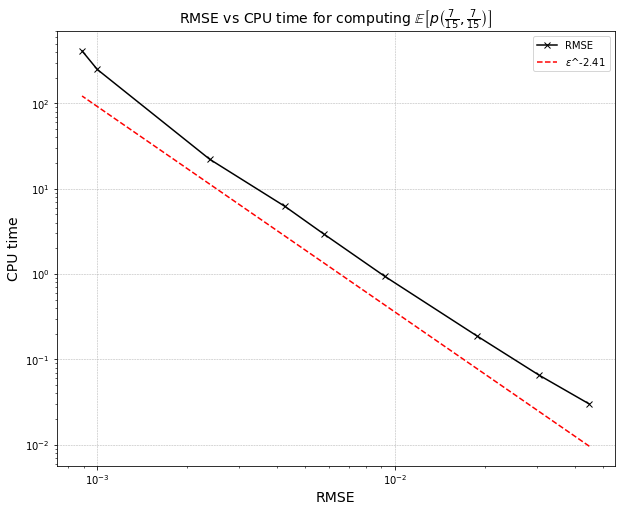

In [75]:
# THIS CELL IS FOR PLOTTING MLMC TIME VS RMSE GRAPH
plt.figure(6, figsize=(10,8))
# use log-log scale
plt.loglog(rmse_vec[:], time_vec[:], 'k-x', label = "RMSE")
# compute best linear fit only for last 5 values
slope, interc = \
    np.polyfit(x=np.log(rmse_vec[:]), y=np.log(time_vec[:]), deg=1)
# compute y values for best linear fit
y_fit = np.exp(slope*np.log(rmse_vec[:]) + interc)
# plot best linear fit
plt.loglog(rmse_vec[:], 0.4*y_fit, 'r--', label = rf'$\epsilon$^{round(slope,2)}')

plt.title(r'RMSE vs CPU time for computing $\mathbb{E}\left[p\left(\frac{7}{15}, \frac{7}{15}\right)\right]$', fontsize=14)
plt.xlabel('RMSE', fontsize=14)
plt.ylabel('CPU time', fontsize=14)
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.show()

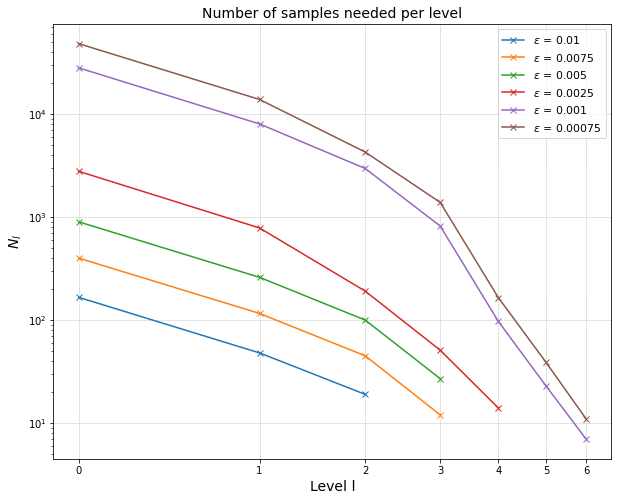

In [72]:
# THIS CELL IS FOR PLOTTING NUMBER OF SAMPLES PER LEVEL
plt.figure(7, figsize=(10,8))
# vector for number of levels
L_vec = np.array([i for i in range(1, 8)])
# plot for each epsilon in the list where more than one level is used
for i in range(3, 9):
    # number of samples for current epsilon
    N_ls = N_ls_vec[i]
    # use log-log scale
    plt.loglog(L_vec[:len(N_ls)], N_ls, '-x', \
        label=rf'$\epsilon$ = {epsilons[i]}')

plt.title(r'Number of samples needed per level', fontsize=14)
plt.xlabel('Level l', fontsize=14)
plt.ylabel(r'$N_l$', fontsize=14)
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks([1,2,3,4,5,6,7], [0,1,2,3,4,5,6], fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=11)
plt.show()